In [9]:
from dataclasses import dataclass
import pandas as pd
import json

@dataclass
class Values:
    def __init__(self, value: pd.DataFrame):
        self.value = value
        self.value_ma = self.value.rolling(window=7).mean() # 7 is the number of days

    def get(self):
        return {
            'Raw': self.value.fillna(0).to_dict(),
            'Moving Average 7 days': self.value_ma.fillna(0).to_dict()
        }

@dataclass
class Measurement:
    def __init__(self, measurement: pd.DataFrame):
        self.measurement = Values(measurement)
        self.measurement_diff = Values(measurement.diff())

    def get(self):
        return {
            'Cumulative': self.measurement.get(),
            'Daily new': self.measurement_diff.get()
        }

@dataclass
class COVID19:
    def __init__(self, confirmed: pd.DataFrame, deaths: pd.DataFrame, recovered: pd.DataFrame):
        self.confirmed = Measurement(confirmed)
        self.deaths = Measurement(deaths)
        self.recovered = Measurement(recovered)

    def to_json(self):
        return json.dmps({
            'confirmed': self.confirmed.get(),
            'deaths': self.deaths.get(),
            'recovered': self.recovered.get()
        })

In [10]:
import os

# Get the base folder relatively to COVID-19
base_folder = os.path.join('..', 'COVID-19', 'csse_covid_19_data', 'csse_covid_19_time_series')

confirmed = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_confirmed_global.csv'), sep=',')
deaths = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_deaths_global.csv'), sep=',')
recovered = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_recovered_global.csv'), sep=',')
confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,714,784,840,906,933,996,1026,1092,1176,1279
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,475,494,518,539,548,562,584,609,634,663
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,659,673,673,696,704,713,717,717,723,723
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,19,19,19,19,24,24,24,24,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,5
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


In [12]:
import calendar
import datetime

def makeComputations(countries):
    global base_folder

    confirmed = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_confirmed_global.csv'), sep=',')
    deaths = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_deaths_global.csv'), sep=',')
    recovered = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_recovered_global.csv'), sep=',')

    get_total_per_country = lambda df: df.sum(axis=0) if not df.isnull().values.any() else df[df.isna().any(axis=1)]
    # clean_date = lambda df: df.set_index(pd.Index([datetime.date(2000 + int(dd.split('/')[2]), int(dd.split('/')[0]), int(dd.split('/')[1])) for dd in list(df.index.values)]))
    clean_date = lambda df: df.set_index(pd.Index([calendar.timegm(datetime.date(2000 + int(dd.split('/')[2]), int(dd.split('/')[0]), int(dd.split('/')[1])).timetuple()) for dd in list(df.index.values)]))

    # countries = [k for k, _ in countries.items()]

    objs = []
    for obj in [confirmed, deaths, recovered]:
        dfs = []
        for c in countries:
            total = get_total_per_country(obj[obj['Country/Region'] == c])
            if isinstance(total, pd.core.frame.Series):
                total = pd.DataFrame(total)
                total = total.transpose()
            total = total.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
            total = total.set_index(pd.Index(['Total ' + c]))
            total = total.transpose()
            total = clean_date(total)
            dfs.append(total)
        objs.append(pd.concat(dfs, axis=1, sort=False))

    selected = COVID19(objs[0], objs[1], objs[2])

    return selected

all_countries = makeComputations(confirmed['Country/Region'].drop_duplicates())

In [8]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [13]:
countries = ['France']

for country in countries:
    confirmed_cumulative_raw = all_countries.confirmed.measurement.value[f'Total {country}']
    confirmed_cumulative_moving_average = all_countries.confirmed.measurement.value_ma[f'Total {country}']

print(confirmed_cumulative_raw)

1579651200         0
1579737600         0
1579824000         2
1579910400         3
1579996800         3
               ...  
1587254400    152894
1587340800    155275
1587427200    158050
1587513600    155860
1587600000    158183
Name: Total France, Length: 93, dtype: int64


<module 'matplotlib.pyplot' from '/home/gauthier/anaconda3/envs/Science/lib/python3.7/site-packages/matplotlib/pyplot.py'>

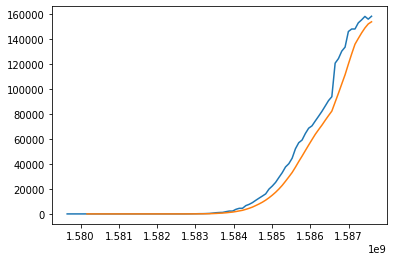

In [10]:
import matplotlib.pyplot as plt

plt.plot(confirmed_cumulative_raw)
plt.plot(confirmed_cumulative_moving_average)
plt